In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.4 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
%cd /content/drive/MyDrive/IS403/Project/Data/

/content/drive/.shortcut-targets-by-id/1H00NdDTisvXwJcMmLshBS2Qn7PUvkU8H/IS403/Project/Data


# Eval Function

In [5]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [6]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [7]:
def train_test_valid(data):
  test_size  = 0.2
  valid_size = 0.1

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  return data[:valid_split_idx], data[valid_split_idx:test_split_idx+1], data[test_split_idx+1:]

# AMAZON

## Data

In [8]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [9]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [11]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [12]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [13]:
close_amz=df_amz[['Close']]

## EDA

### Get the duration of dataset

In [14]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

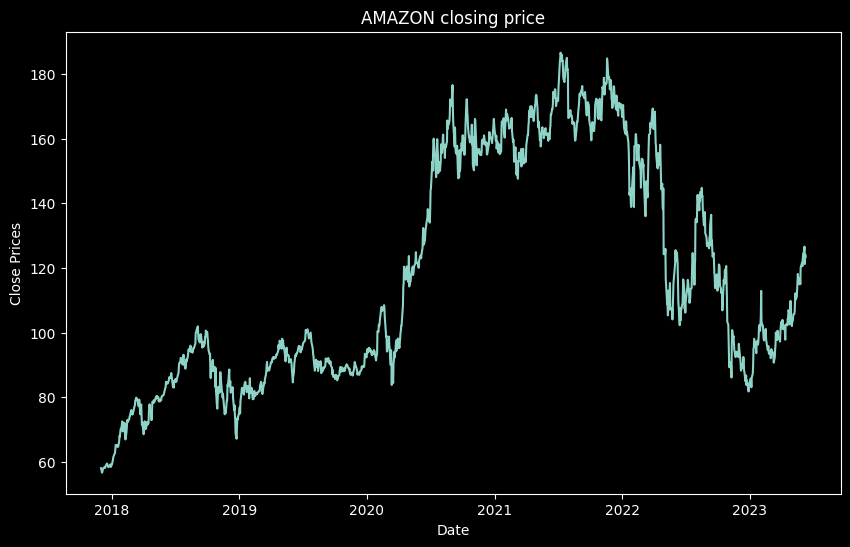

In [15]:
x_axis = np.array(df_amz['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_amz)
plt.title('AMAZON closing price')
plt.show()

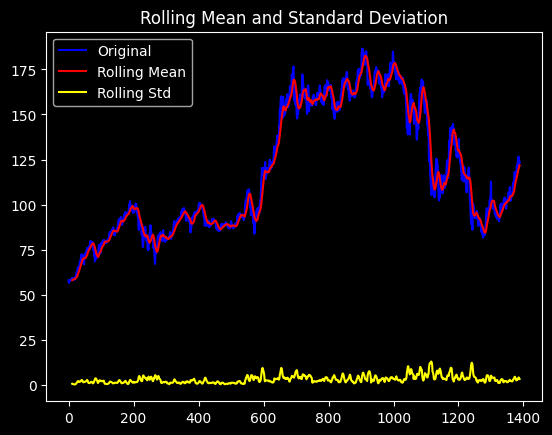

Results of dickey fuller test
Test Statistics                  -1.929368
p-value                           0.318374
No. of lags used                  0.000000
Number of observations used    1388.000000
critical value (1%)              -3.435070
critical value (5%)              -2.863625
critical value (10%)             -2.567880
dtype: float64


In [16]:
test_stationarity(close_amz)

## Train, test, valid

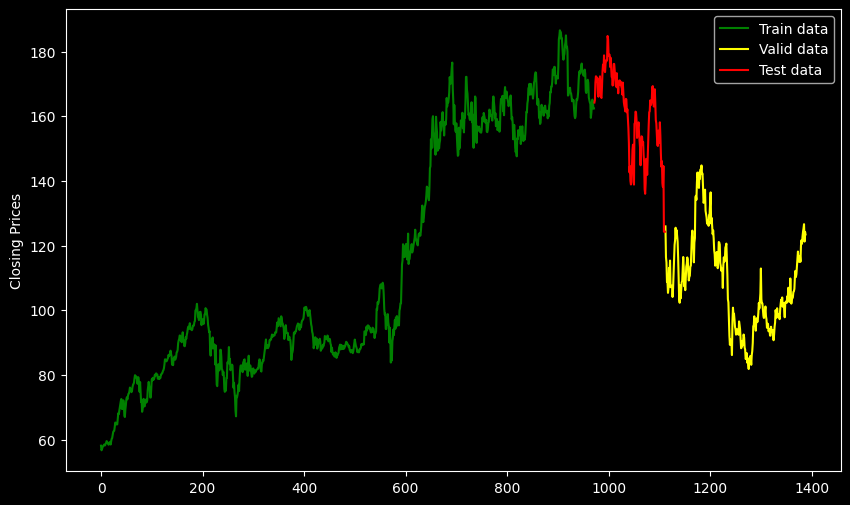

In [17]:
close_amz = close_amz.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_amz)

plt.figure(figsize=(10,6))
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [18]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [19]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12063.099, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4363.062, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4365.053, Time=0.53 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9611.859, Time=2.75 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4362.724, Time=1.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8517.651, Time=0.85 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4363.206, Time=2.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4364.709, Time=1.94 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9779.018, Time=0.09 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  972
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2177.362
Date:                Wed, 21 Jun 2023   AIC                           4362.724
Time:                        03:11:18   BIC                           4382.242
Sample:                             0   HQIC                          4370.152
                                - 972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1363      0.187      0.729      0.466      -0.230       0.503
ar.L1          0.9988      0.002    610.374      0.000       0.996       1.002
ma.L1         -0.0282      0.024     -1.149      0.250      -0.076       0.020
sigma2         5.1354      0.136     37.704      0.000       4.868       5.402
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               621.53
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [20]:
model = ARIMA(y_train, order=(1,0,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  972
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2177.364
Date:                Wed, 21 Jun 2023   AIC                           4362.728
Time:                        03:11:19   BIC                           4382.245
Sample:                             0   HQIC                          4370.156
                                - 972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.7629     30.562      3.722      0.000      53.862     173.664
ar.L1          0.9988      0.002    609.909      0.000       0.996       1.002
ma.L1         -0.0282      0.024     -1.149      0.251      -0.076       0.020
sigma2         5.1356      0.136     37.702      0.000       4.869       5.403
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               621.12
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [21]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [22]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  9.659465014613783
MAPE:  6.105550143127616
RMSE:  11.4999945184065

** Validate **
MAE:  39.90660343952285
MAPE:  38.99937485594644
RMSE:  42.13538579068826


## Forecast

In [23]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[142.93738799 142.90178805 142.86623154 142.83071843 142.79524864
 142.75982214 142.72443887 142.68909878 142.65380181 142.61854791
 142.58333702 142.54816911 142.5130441  142.47796196 142.44292263
 142.40792605 142.37297218 142.33806095 142.30319233 142.26836626
 142.23358268 142.19884155 142.16414281 142.12948641 142.0948723
 142.06030043 142.02577074 141.99128319 141.95683772 141.92243429]


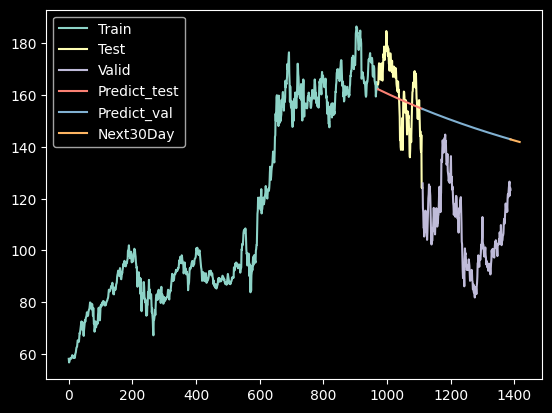

In [24]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# NVIDIA

## Data

In [25]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [26]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [27]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [28]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [29]:
df_nvda['Date'] = pd.to_datetime(df_nvda.Date)

### Choose X

In [30]:
close_nvda = df_nvda[['Close']]

## EDA

### Get the duration of dataset

In [31]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])
print("Duration: ", df_nvda.iloc[-1][0]-df_nvda.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

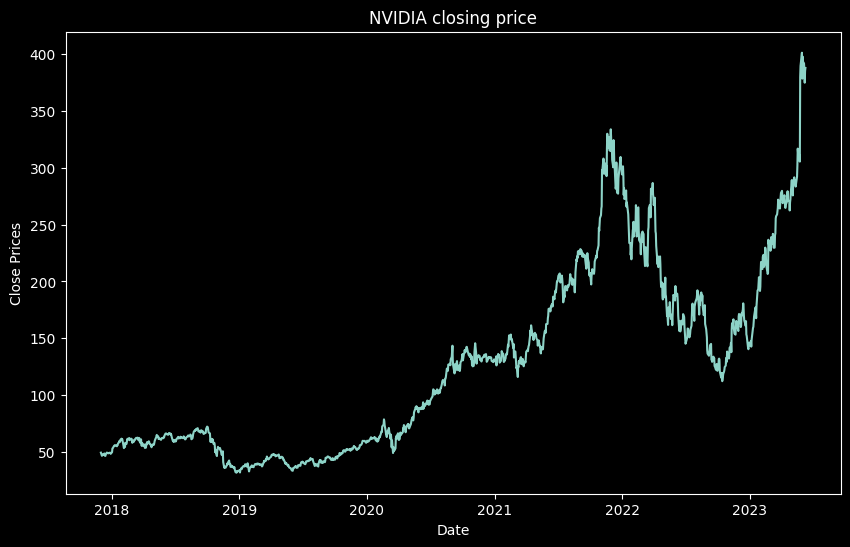

In [32]:
x_axis = np.array(df_nvda['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_nvda)
plt.title('NVIDIA closing price')
plt.show()

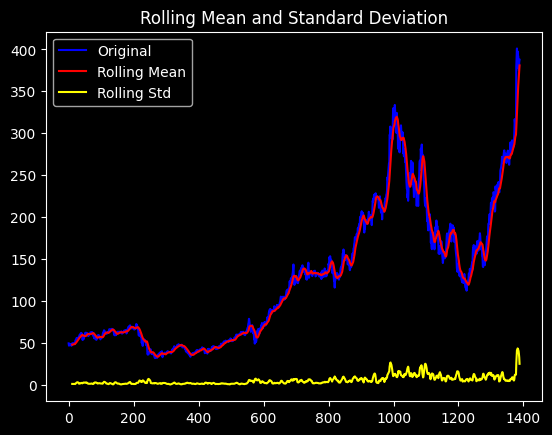

Results of dickey fuller test
Test Statistics                   0.624465
p-value                           0.988203
No. of lags used                 17.000000
Number of observations used    1371.000000
critical value (1%)              -3.435129
critical value (5%)              -2.863650
critical value (10%)             -2.567894
dtype: float64


In [33]:
test_stationarity(close_nvda)

## Train, test, valid

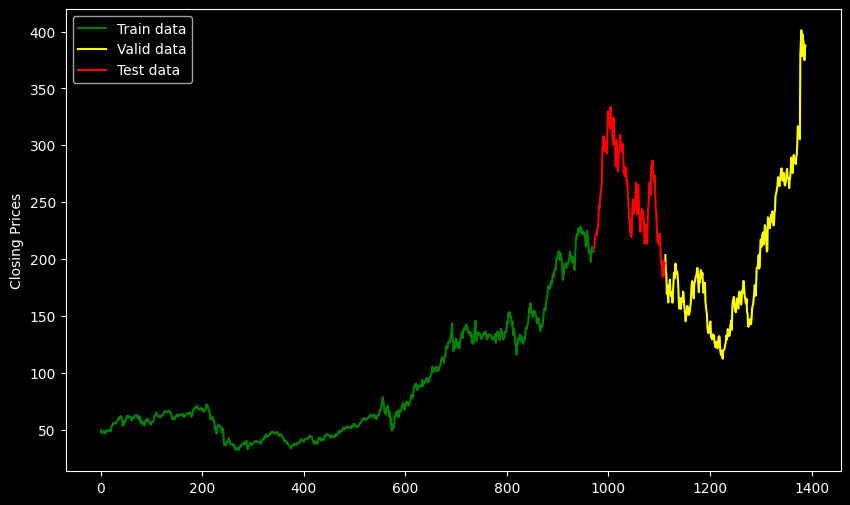

In [34]:
close_nvda = close_nvda.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_nvda)

plt.figure(figsize=(10,6))
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [35]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [36]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11735.631, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10430.694, Time=0.62 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4660.250, Time=1.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4660.128, Time=1.96 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4664.016, Time=2.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4664.242, Time=1.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4661.136, Time=1.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=1.62 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4656.618, Time=2.44 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=4658.619, Time=1.81 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4658.622, Time=1.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4665.049, Time=0.69 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4664

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  972
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -2322.309
Date:                Wed, 21 Jun 2023   AIC                           4656.618
Time:                        03:11:49   BIC                           4685.894
Sample:                             0   HQIC                          4667.760
                                - 972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7149      0.057    -12.548      0.000      -0.827      -0.603
ar.L2          0.8078      0.024     33.622      0.000       0.761       0.855
ar.L3          0.9065      0.053     17.071      0.000       0.802       1.011
ma.L1          1.6665      0.064     26.212      0.000       1.542       1.791
ma.L2          0.8664      0.059     14.743      0.000       0.751       0.982
sigma2         6.9049      0.189     36.606      0.000       6.535       7.275
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               580.03
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               5.95   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [37]:
model = ARIMA(y_train, order=(3,0,2)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  972
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2321.648
Date:                Wed, 21 Jun 2023   AIC                           4657.296
Time:                        03:11:53   BIC                           4691.452
Sample:                             0   HQIC                          4670.296
                                - 972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.2677    180.581      0.483      0.629    -266.664     441.200
ar.L1         -0.7154      0.057    -12.512      0.000      -0.827      -0.603
ar.L2          0.8074      0.024     33.324      0.000       0.760       0.855
ar.L3          0.9060      0.053     16.998      0.000       0.802       1.010
ma.L1          1.6666      0.064     26.137      0.000       1.542       1.792
ma.L2          0.8662      0.059     14.676      0.000       0.750       0.982
sigma2         6.9041      0.190     36.373      0.000       6.532       7.276
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               574.95
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               5.95   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [38]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [39]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  57.7497407761046
MAPE:  20.830005702453093
RMSE:  67.2338448519618

** Validate **
MAE:  52.02684689847049
MAPE:  25.90542034592742
RMSE:  67.20575441480187


## Forecast

In [40]:
last_index =  close_nvda.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[182.29107075 182.2393187  182.18759485 182.13589916 182.08423163
 182.03259224 181.98098097 181.92939781 181.87784274 181.82631575
 181.77481683 181.72334595 181.6719031  181.62048828 181.56910145
 181.51774261 181.46641174 181.41510883 181.36383386 181.31258681
 181.26136767 181.21017643 181.15901307 181.10787758 181.05676993
 181.00569012 180.95463812 180.90361394 180.85261754 180.80164891]


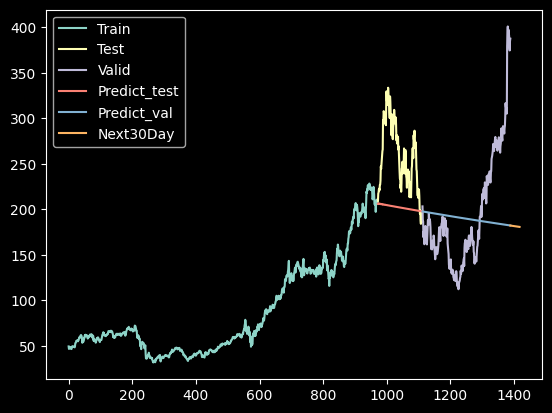

In [41]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# TESLA

## Data

In [42]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [43]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [44]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [45]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [46]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [47]:
close_tsla = df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [48]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

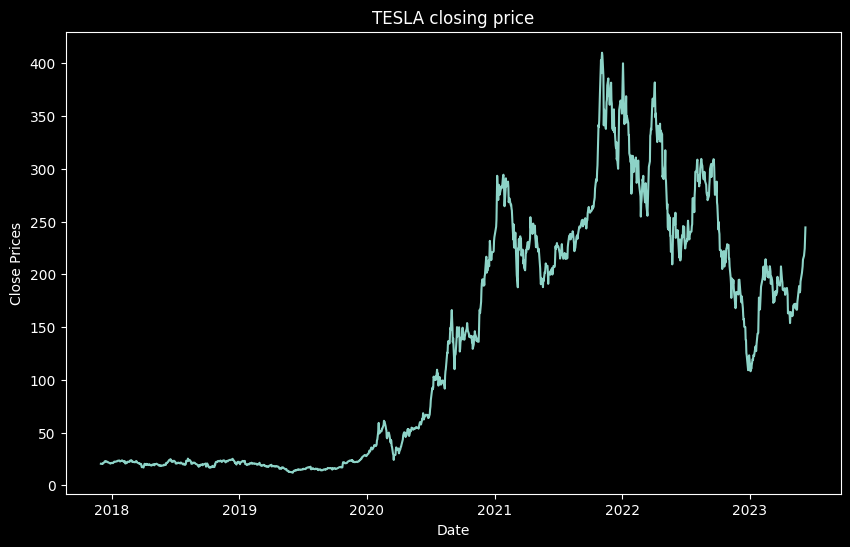

In [49]:
x_axis = np.array(df_tsla['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_tsla)
plt.title('TESLA closing price')
plt.show()

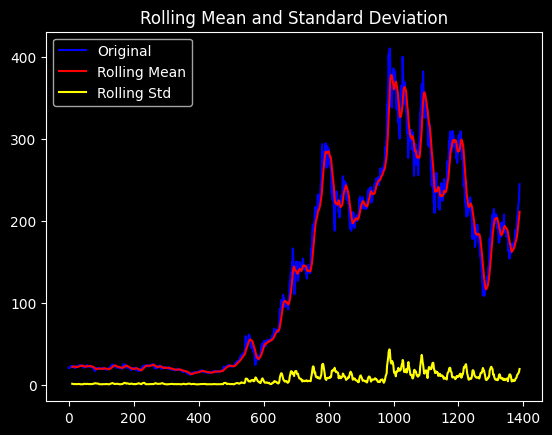

Results of dickey fuller test
Test Statistics                  -1.267376
p-value                           0.643963
No. of lags used                 24.000000
Number of observations used    1364.000000
critical value (1%)              -3.435153
critical value (5%)              -2.863661
critical value (10%)             -2.567899
dtype: float64


In [50]:
test_stationarity(close_tsla)

## Train, test, valid

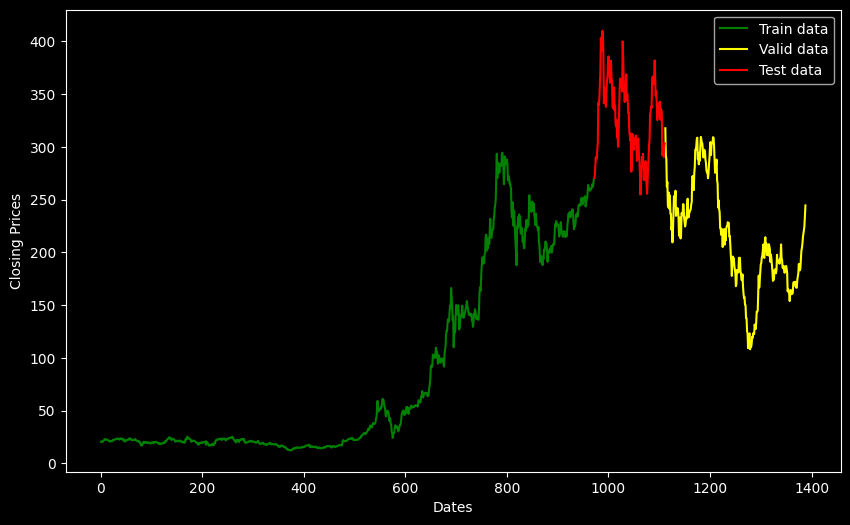

In [51]:
close_tsla = close_tsla.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_tsla)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [52]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [53]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12092.896, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10809.628, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5632.268, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5636.671, Time=0.76 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5634.199, Time=0.94 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9710.950, Time=1.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5635.524, Time=1.55 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5633.248, Time=0.83 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 6.726 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  972
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2813.134
Date:                Wed, 21 Jun 2023   AIC                           5632.268
Time:                        03:12:02   BIC                           5646.906
Sample:                             0   HQIC                          5637.840
                                - 972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   2458.186      0.000       0.999       1.001
ma.L1         -0.0706      0.015     -4.689      0.000      -0.100      -0.041
sigma2        18.9691      0.334     56.760      0.000      18.314      19.624
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5666.45
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):             102.15   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [54]:
model = ARIMA(y_train, order=(1,0,1)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  972
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2812.725
Date:                Wed, 21 Jun 2023   AIC                           5633.450
Time:                        03:12:02   BIC                           5652.968
Sample:                             0   HQIC                          5640.879
                                - 972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.3612    403.969      0.206      0.837    -708.404     875.127
ar.L1          0.9995      0.002    505.439      0.000       0.996       1.003
ma.L1         -0.0704      0.015     -4.614      0.000      -0.100      -0.040
sigma2        18.9671      0.335     56.659      0.000      18.311      19.623
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5659.42
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              99.03   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [56]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  66.79800371664255
MAPE:  19.40351273437519
RMSE:  75.52558106757321

** Validate **
MAE:  46.03654163382529
MAPE:  25.94655322232406
RMSE:  54.473491719384214


## Forecast

In [57]:
last_index =  close_tsla.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[230.9223744  230.84281933 230.76330715 230.68383783 230.60441136
 230.52502771 230.44568686 230.36638879 230.28713347 230.20792087
 230.12875099 230.04962378 229.97053924 229.89149733 229.81249804
 229.73354134 229.6546272  229.57575562 229.49692655 229.41813998
 229.33939589 229.26069426 229.18203505 229.10341825 229.02484384
 228.94631179 228.86782208 228.78937468 228.71096958 228.63260675]


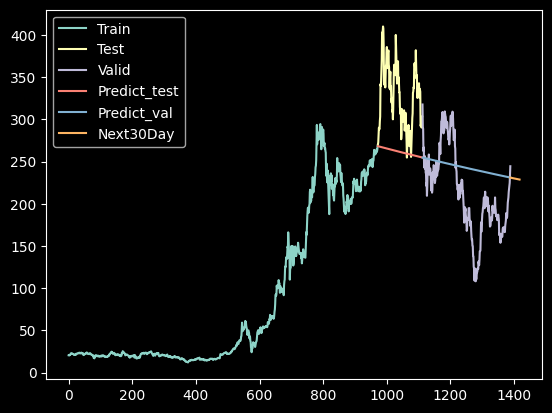

In [58]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()